# Garbage Classification


### Data Visualization
The dataset contains about 2,500 images of garbage, including "cardboard", "glass", "metal", "paper", "plastic", and images that don't belong to any of those categories, simply labeled as "trash".

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

Generating the data

In [2]:
def generate_data(data_path, grayscale=False, downscale=None):
    cardboard, glass, metal, paper, plastic, trash = [], [], [], [], [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if ".jpg" in file:

                if grayscale:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
                
                if downscale:
                    new_size = (int(img.shape[1]/downscale), int(img.shape[0]/downscale))
                    img = cv2.resize(img, new_size)

                if "cardboard" in file: cardboard.append(img)
                elif "glass" in file: glass.append(img)
                elif "metal" in file: metal.append(img)
                elif "paper" in file: paper.append(img)
                elif "plastic" in file: plastic.append(img)
                elif "trash" in file: trash.append(img)
                else: print(f"Unable to classify image: {file}")
    images = {"cardboard": np.array(cardboard), "glass": np.array(glass), "metal": np.array(metal),
              "paper": np.array(paper), "plastic": np.array(plastic), "trash": np.array(trash)}
    return images

In [3]:
original_images = generate_data("data")
for key, value in original_images.items():
    print(f"{key}: {value.shape}")

cardboard: (403, 384, 512, 3)
glass: (501, 384, 512, 3)
metal: (410, 384, 512, 3)
paper: (594, 384, 512, 3)
plastic: (482, 384, 512, 3)
trash: (137, 384, 512, 3)


In [4]:
def show_sample(images, sample_number):
    fig = plt.figure(figsize=(10, 7))
    rows, columns = 1, 6
    for i, (key, value) in enumerate(images.items()):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(value[sample_number])
        plt.axis('off')
        plt.title(key)

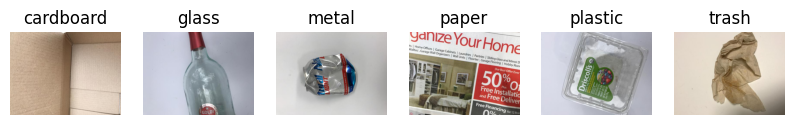

In [5]:
show_sample(original_images, 5)

### 1. Logistic Regression

Logistic regression is usually a binary classification algorithm. It models the probability of a binary response variable based on one or more predictor variables.

However, it can be extended to handle multiclass classification problems by using a technique called one-vs-all (OVA) or one-vs-rest (OVR) classification.

In OVA, we create one binary logistic regression classifier for each class, which predicts whether an observation belongs to that class or not. To make a prediction, we apply each classifier to the observation and select the class with the highest predicted probability.

In OVR, we create one binary logistic regression classifier for each pair of classes. For example, if we have three classes A, B, and C, we would create three classifiers: one for A vs. (B or C), one for B vs. (A or C), and one for C vs. (A or B). To make a prediction, we apply each classifier to the observation and assign the observation to the class with the most "votes" from the classifiers.

#### Scikit Learn's Logistic Regression model uses OVR.

In both cases, logistic regression uses a linear function of the predictor variables, transformed by the logistic function, to model the probability of the response variable. The model parameters are estimated using maximum likelihood estimation, and regularization techniques can be applied to prevent overfitting.

In [6]:
labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

# splitting the data
def train_test_split(images, train_size=0.8):
    data = []
    for key, value in images.items():
        for img in value: 
            data.append([img, labels[key]])
    
    random.shuffle(data)
    train_size = int(len(data) * train_size)

    X_train = np.array([e[0] for e in data[:train_size]])
    y_train = np.array([e[1] for e in data[:train_size]])

    X_test = np.array([e[0] for e in data[train_size:]])
    y_test = np.array([e[1] for e in data[train_size:]])

    return X_train, y_train, X_test, y_test

In [7]:
from sklearn.linear_model import LogisticRegression

Applying preprocessing (grayscaling and downscaling the images), as well as normalizing the values
(originaly the pixel's values were 0-255, we normalize it to 0.0-1.0)

Normalizing the values provides an improved model convergence, as well as better performance for many machine learning models (such as knn, svm, and neural networks - all of which I use in this project).

X_train values: 1.0, 0.0
X_test values: 1.0, 0.0
X_Train: (2274, 3072)
y_train: (2274,)
X_test: (253, 3072)
y_test: (253,)


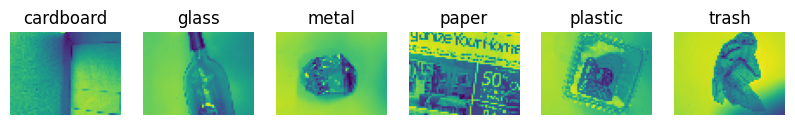

In [8]:
grayscale_downscale = generate_data("data", grayscale=True, downscale=8)
show_sample(grayscale_downscale, 5)

X_train, y_train, X_test, y_test = train_test_split(grayscale_downscale, train_size=0.9)

# Flattening the images. Logistic regression accepts vectors, not matrices.
X_train_flattened = (X_train.reshape(X_train.shape[0], int(X_train.size / X_train.shape[0]))) / 255.0
X_test_flattened = (X_test.reshape(X_test.shape[0], int(X_test.size / X_test.shape[0]))) / 255.0

print(f"X_train values: {np.max(X_train_flattened)}, {np.min(X_train_flattened)}\nX_test values: {np.max(X_test_flattened)}, {np.min(X_test_flattened)}")

print(f"X_Train: {X_train_flattened.shape}\ny_train: {y_train.shape}\nX_test: {X_test_flattened.shape}\ny_test: {y_test.shape}")

In [9]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_flattened, y_train)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Visualizing the results

In [10]:
from sklearn import metrics
import seaborn as sns

In [11]:
def show_confusion_matrix(confusion_matrix, score):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, annot=True, linewidths=0.5, square=True, cmap="Blues_r")
    plt.xlabel("Actual Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Accuracy Score: {score}")

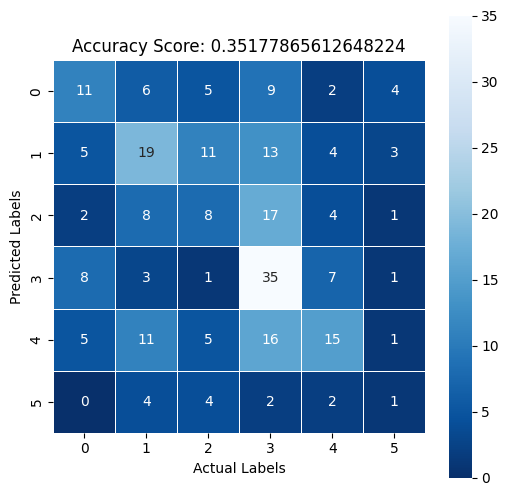

In [12]:
y_pred = logistic_regression.predict(X_test_flattened)
score = logistic_regression.score(X_test_flattened, y_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

show_confusion_matrix(confusion_matrix, score)

It seems class 3 (paper) is the easiest to classify truely

### PCA

Principal Component Analysis - A dimentionality reduction technique, used to reduce the number of dimentions of datasets while preserving the most important features (or combination of features), that captures the most variation of data.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

We run an algorithm to find out the optimal number of components (features).
I want a maximum of 50 features, in order for the algorithm to run fast as well as perform good.
(After running the PCA algorithm with as much as 1000 features, I found out that about the same results can be reached using as low number as 100 features)

In [14]:
sc = StandardScaler()

accuracies = {}
max_n_components = 50

for n in range(1, max_n_components+1):
    X_train_pca = sc.fit_transform(X_train_flattened)
    X_test_pca = sc.transform(X_test_flattened)

    pca = PCA(n_components=n)

    X_train_pca = pca.fit_transform(X_train_flattened)
    X_test_pca = pca.transform(X_test_flattened)

    logistic_regression_pca = LogisticRegression(max_iter=200)
    logistic_regression_pca.fit(X_train_pca, y_train)

    score_pca = logistic_regression_pca.score(X_test_pca, y_test)

    print(f"n components: {n}/{max_n_components}, accuracy: {score_pca}")

    accuracies[n] = score_pca

n components: 1/50, accuracy: 0.20553359683794467
n components: 2/50, accuracy: 0.2134387351778656
n components: 3/50, accuracy: 0.2727272727272727
n components: 4/50, accuracy: 0.30434782608695654
n components: 5/50, accuracy: 0.2766798418972332
n components: 6/50, accuracy: 0.31620553359683795
n components: 7/50, accuracy: 0.3241106719367589
n components: 8/50, accuracy: 0.3794466403162055
n components: 9/50, accuracy: 0.3794466403162055
n components: 10/50, accuracy: 0.38735177865612647
n components: 11/50, accuracy: 0.3952569169960474
n components: 12/50, accuracy: 0.3952569169960474
n components: 13/50, accuracy: 0.383399209486166
n components: 14/50, accuracy: 0.3952569169960474
n components: 15/50, accuracy: 0.40711462450592883
n components: 16/50, accuracy: 0.41106719367588934
n components: 17/50, accuracy: 0.4189723320158103
n components: 18/50, accuracy: 0.4150197628458498
n components: 19/50, accuracy: 0.39920948616600793
n components: 20/50, accuracy: 0.39920948616600793
n 

We find out the best number of features based on validation accuracy.

In [15]:
best_n_components = max(accuracies, key=accuracies.get)

X_train_pca = sc.fit_transform(X_train_flattened)
X_test_pca = sc.transform(X_test_flattened)

pca = PCA(n_components=best_n_components)

X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.transform(X_test_flattened)

print(f"Best n componenets: {best_n_components}")

logistic_regression_pca = LogisticRegression()
logistic_regression_pca.fit(X_train_pca, y_train)

Best n componenets: 17


LogisticRegression()

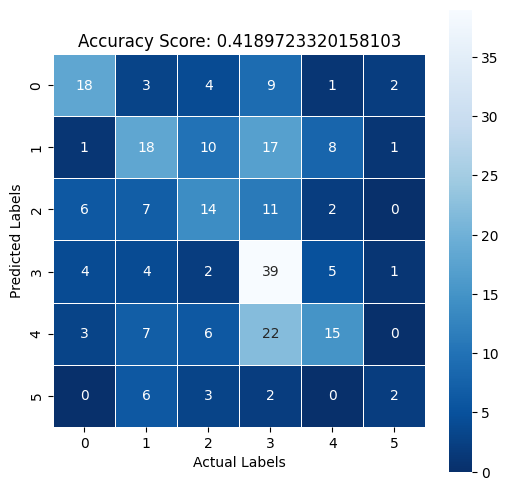

In [16]:
y_pred_pca = logistic_regression_pca.predict(X_test_pca)
score_pca = logistic_regression_pca.score(X_test_pca, y_test)
confusion_matrix_pca = metrics.confusion_matrix(y_test, y_pred_pca)

show_confusion_matrix(confusion_matrix_pca, score_pca)

And just with 9 features, we not only got an accuracy of 41% (there are 6 classes - a dummy classifier would guess and get an average accuracy of ~16%), but it is also an improvement over using the flattened image (grayscaled and downscaled)

### KNN

K-Nearest Neighbors - the algorithm works by finding the K nearest data points in the training set to a given input data point in the feature space

The K nearest data points are used to determine the class label of the input data point by majority vote, so if the K neighbors have a majority of being of "glass" type, the currect data vector is probably also of "Glass" type.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

We also need to find out the best number of k-neighbors for the algorithm.

Usually the number is not very high, so I want a maximum of 50 neighbors.

In [18]:
knn_accuracies = {}
max_k_neighbors = 50

for k in range(1, max_k_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_flattened, y_train)

    score_knn = knn.score(X_test_flattened, y_test)
    knn_accuracies[k] = score

    print(f"n components: {k}/{max_k_neighbors}, accuracy: {score_knn}")

n components: 1/50, accuracy: 0.43478260869565216
n components: 2/50, accuracy: 0.4308300395256917
n components: 3/50, accuracy: 0.4189723320158103
n components: 4/50, accuracy: 0.43478260869565216
n components: 5/50, accuracy: 0.42292490118577075
n components: 6/50, accuracy: 0.43478260869565216
n components: 7/50, accuracy: 0.4150197628458498
n components: 8/50, accuracy: 0.42292490118577075
n components: 9/50, accuracy: 0.42292490118577075
n components: 10/50, accuracy: 0.42292490118577075
n components: 11/50, accuracy: 0.4150197628458498
n components: 12/50, accuracy: 0.41106719367588934
n components: 13/50, accuracy: 0.41106719367588934
n components: 14/50, accuracy: 0.3952569169960474
n components: 15/50, accuracy: 0.391304347826087
n components: 16/50, accuracy: 0.3715415019762846
n components: 17/50, accuracy: 0.3794466403162055
n components: 18/50, accuracy: 0.39920948616600793
n components: 19/50, accuracy: 0.383399209486166
n components: 20/50, accuracy: 0.383399209486166
n 

In a similar way to PCA, we use the best number of k-neighbors based on the validation accuracy.

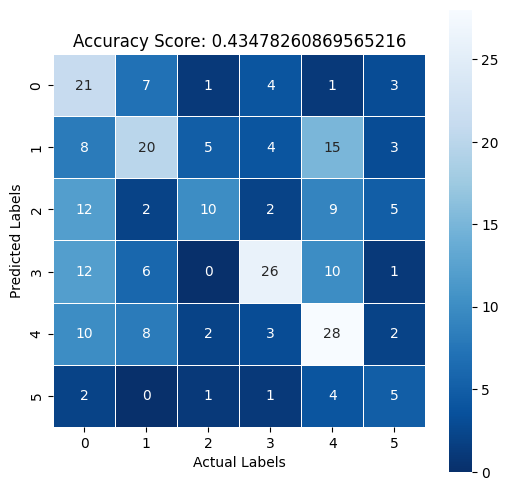

In [19]:
best_k_neighbors = max(knn_accuracies, key=knn_accuracies.get)

knn = KNeighborsClassifier(n_neighbors=best_k_neighbors)
knn.fit(X_train_flattened, y_train)

y_pred_knn = knn.predict(X_test_flattened)
score_knn = knn.score(X_test_flattened, y_test)
confusion_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)

show_confusion_matrix(confusion_matrix_knn, score_knn)

A slight improvement over Logistic Regression, but can be better.

We will use PCA here as well.

In [20]:
knn_pca_accuracies = {}
max_n_components = 50

for n in range(1, max_n_components+1):
    X_train_pca = sc.fit_transform(X_train_flattened)
    X_test_pca = sc.transform(X_test_flattened)

    pca = PCA(n_components=n)

    X_train_pca = pca.fit_transform(X_train_flattened)
    X_test_pca = pca.transform(X_test_flattened)

    knn_pca = KNeighborsClassifier(n_neighbors=best_k_neighbors)
    knn_pca.fit(X_train_pca, y_train)

    score_knn_pca = knn_pca.score(X_test_pca, y_test)

    print(f"n components: {n}/{max_n_components}, accuracy: {score_knn_pca}")

    knn_pca_accuracies[n] = score_knn_pca

n components: 1/50, accuracy: 0.24110671936758893
n components: 2/50, accuracy: 0.25691699604743085
n components: 3/50, accuracy: 0.35177865612648224
n components: 4/50, accuracy: 0.4031620553359684
n components: 5/50, accuracy: 0.466403162055336
n components: 6/50, accuracy: 0.48221343873517786
n components: 7/50, accuracy: 0.47035573122529645
n components: 8/50, accuracy: 0.5059288537549407
n components: 9/50, accuracy: 0.5019762845849802
n components: 10/50, accuracy: 0.5098814229249012
n components: 11/50, accuracy: 0.5138339920948617
n components: 12/50, accuracy: 0.525691699604743
n components: 13/50, accuracy: 0.5296442687747036
n components: 14/50, accuracy: 0.5177865612648221
n components: 15/50, accuracy: 0.5177865612648221
n components: 16/50, accuracy: 0.525691699604743
n components: 17/50, accuracy: 0.5335968379446641
n components: 18/50, accuracy: 0.5296442687747036
n components: 19/50, accuracy: 0.5019762845849802
n components: 20/50, accuracy: 0.5019762845849802
n compo

In [21]:
best_n_components_knn = max(knn_pca_accuracies, key=knn_pca_accuracies.get)

X_train_pca = sc.fit_transform(X_train_flattened)
X_test_pca = sc.transform(X_test_flattened)

pca = PCA(n_components=best_n_components_knn)

X_train_pca = pca.fit_transform(X_train_flattened)
X_test_pca = pca.transform(X_test_flattened)

print(f"Best n componenets: {best_n_components_knn}")

knn_pca = KNeighborsClassifier(n_neighbors=best_k_neighbors)
knn_pca.fit(X_train_pca, y_train)

Best n componenets: 17


KNeighborsClassifier(n_neighbors=1)

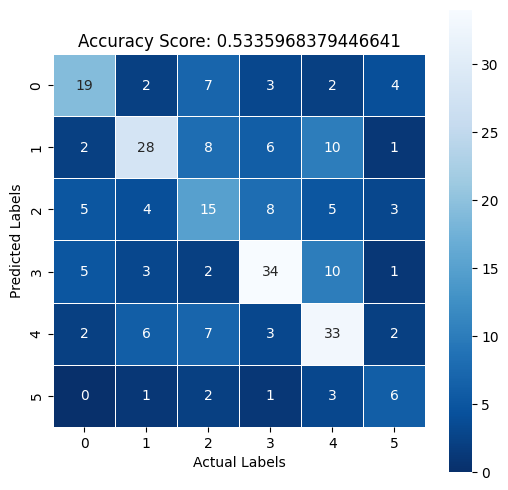

In [22]:
y_pred_knn_pca = knn_pca.predict(X_test_pca)
score_knn_pca = knn_pca.score(X_test_pca, y_test)
confusion_matrix_knn_pca = metrics.confusion_matrix(y_test, y_pred_knn_pca)

show_confusion_matrix(confusion_matrix_knn_pca, score_knn_pca)

An accuracy of 53% using a KNN model.

We will next use models that is more fit for large datasets (KNN and Logistic regression work better with smaller datasets)